In [66]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy

In [67]:
journey_profiles = pandas.read_parquet("journey_profiles")
journey_profiles["IS_MAX_ONLY"] = journey_profiles["LINE_IDS_USED"].apply(lambda x: set(x).issubset(set([100,200,90,190,290])))
journey_profiles.loc[journey_profiles["INCLUDES_MAX"]==1,"INCLUDES_MAX"] = "Yes"
journey_profiles.loc[journey_profiles["INCLUDES_MAX"]==0,"INCLUDES_MAX"] = "No"
journey_profiles["ORIGIN_DESTINATION_DISTANCE_FT"] = journey_profiles["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3
journey_profiles.loc[journey_profiles["IS_SINGLE_STOP_RIDE"]==1,"IS_SINGLE_STOP_RIDE"] = "Yes"
journey_profiles.loc[journey_profiles["IS_SINGLE_STOP_RIDE"]==0,"IS_SINGLE_STOP_RIDE"] = "No"

# Evaluate effectiveness of Loop Tag

In [68]:
#loop tag analysis
print(
    journey_profiles.groupby(["IS_SINGLE_STOP_RIDE"])["ORIGIN_DESTINATION_DISTANCE_FT"].describe(
    percentiles = [x/100 for x in range(0,100,10)]).T,
    "\n",
    journey_profiles[
        journey_profiles["ORIGIN_DESTINATION_DISTANCE_FT"]<200
        ].groupby(["IS_SINGLE_STOP_RIDE"],as_index = False)["JOURNEY_ID"].count().T
    )


IS_SINGLE_STOP_RIDE            No            Yes
count                1.381041e+06  133194.000000
mean                 1.900887e+04    2671.951636
std                  1.461763e+04    2534.049112
min                  0.000000e+00     162.089748
0%                   0.000000e+00     162.089748
10%                  4.231493e+03     765.482988
20%                  6.839420e+03     939.661997
30%                  9.585046e+03    1095.839419
40%                  1.250701e+04    1316.757742
50%                  1.553391e+04    1577.392890
60%                  1.897696e+04    2278.342704
70%                  2.353695e+04    2884.909148
80%                  2.905391e+04    4025.907309
90%                  3.763208e+04    5989.721910
max                  1.747347e+05   16565.859459 
                         0    1
IS_SINGLE_STOP_RIDE    No  Yes
JOURNEY_ID           6066    5


# Calculate Validity Score and analyze

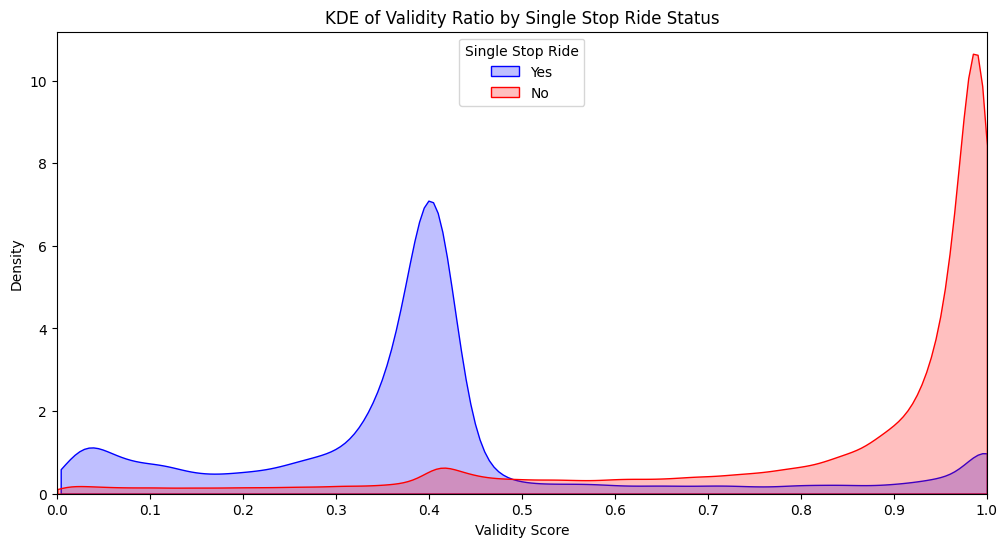

In [69]:
# Create the KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"] == "Yes"], 
    x="VALIDITY_SCORE", 
    color="blue",
    fill=True,
    label="Yes",
    cut=0
)

sns.kdeplot(
    data=journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"] == "No"], 
    x="VALIDITY_SCORE", 
    color="red",
    fill=True,
    label="No",
    cut=0
)

plt.legend(title = "Single Stop Ride", loc='upper center')
plt.title("KDE of Validity Ratio by Single Stop Ride Status")
plt.xlabel("Validity Score")
plt.ylabel("Density")

# Limit x-axis to focus on the main distribution
plt.xlim(0,1)
plt.xticks(numpy.arange(0,1+.10,0.1))

plt.show()

In [70]:
journey_profiles.groupby(
    by = ["IS_SINGLE_STOP_RIDE"]
    )["VALIDITY_SCORE"].describe(
        percentiles = [x/100 for x in range(0,100,10)]
        ).T

IS_SINGLE_STOP_RIDE,No,Yes
count,1.381041e+06,133194.000000
mean,8.417131e-01,0.404660
std,2.330565e-01,0.228950
min,4.803905e-04,0.004073
0%,4.803905e-04,0.004073
10%,4.410705e-01,0.104442
20%,7.126784e-01,0.270857
30%,8.641151e-01,0.349215
40%,9.270845e-01,0.379349
50%,9.571550e-01,0.395638


# Analyze impacts of Validity Score Cutoffs

In [72]:
#impact of validity score cutoff of 0.50
cutoff = 0.50
journey_profiles["ABOVE_CUTOFF"] = journey_profiles["VALIDITY_SCORE"] > cutoff
median_distance_above_cutoff = (journey_profiles[journey_profiles["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (journey_profiles["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (journey_profiles[journey_profiles["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (journey_profiles["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = journey_profiles[journey_profiles["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = journey_profiles["N_LEGS"].mean()-1
n_bus_only = len(journey_profiles[journey_profiles["INCLUDES_MAX"]=="No"])
n_bus_and_max = len(journey_profiles[(journey_profiles["INCLUDES_MAX"]=="Yes")&(~journey_profiles["IS_MAX_ONLY"])])
n_max_only = len(journey_profiles[journey_profiles["IS_MAX_ONLY"]])
n_bus_only_above_cutoff = len(journey_profiles[(journey_profiles["INCLUDES_MAX"]=="No") & (journey_profiles["ABOVE_CUTOFF"])])
n_bus_and_max_above_cutoff = len(journey_profiles[(journey_profiles["INCLUDES_MAX"]=="Yes") & (~journey_profiles["IS_MAX_ONLY"]) & (journey_profiles["ABOVE_CUTOFF"])])
n_max_only_above_cutoff = len(journey_profiles[(journey_profiles["IS_MAX_ONLY"]) & (journey_profiles["ABOVE_CUTOFF"])])
n_single_stop_journeys = len(journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"]=="Yes"])
n_single_stop_journeys_above_cutoff = len(journey_profiles[(journey_profiles["IS_SINGLE_STOP_RIDE"]=="Yes")&journey_profiles["ABOVE_CUTOFF"]])

# Create a table of statistics
stats_table = {
    "Statistic": [
        "Number of Journeys",
        "Number of Single Stop Rides",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers",
        "Bus Only Journeys",
        "Bus and MAX Journeys",
        "MAX Only Journeys"
    ],"All Journeys": [
        f"{len(journey_profiles)}",
        f"{n_single_stop_journeys}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}",
        f"{n_bus_only}",
        f"{n_bus_and_max}",
        f"{n_max_only}"
    ],
    "Above Cutoff": [
        f"{len(journey_profiles[journey_profiles['ABOVE_CUTOFF']])}",
        f"{n_single_stop_journeys_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}",
        f"{n_bus_only_above_cutoff}",
        f"{n_bus_and_max_above_cutoff}",
        f"{n_max_only_above_cutoff}"
    ],
    "Percent Change": [
        f"{(len(journey_profiles[journey_profiles['ABOVE_CUTOFF']])-len(journey_profiles))/len(journey_profiles)*100:.2f}",
        f"{(n_single_stop_journeys_above_cutoff-n_single_stop_journeys)/n_single_stop_journeys*100:.2f}",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%",
        f"{(n_bus_only_above_cutoff - n_bus_only) / n_bus_only * 100:.2f}%",
        f"{(n_bus_and_max_above_cutoff - n_bus_and_max) / n_bus_and_max * 100:.2f}%",
        f"{(n_max_only_above_cutoff - n_max_only) / n_max_only * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))


                    Statistic All Journeys Above Cutoff Percent Change
           Number of Journeys      1514235      1232488         -18.61
  Number of Single Stop Rides       133194        21250         -84.05
      Median Distance (miles)         2.67         2.94         10.04%
Median Journey Time (minutes)        17.83        19.47          9.16%
     Mean Number of Transfers         0.28         0.30          6.98%
            Bus Only Journeys      1204284      1010794        -16.07%
         Bus and MAX Journeys        40783        34741        -14.81%
            MAX Only Journeys       269168       186953        -30.54%


In [65]:
journey_profiles[
    (journey_profiles["IS_SINGLE_STOP_RIDE"]==1)
    ]["VALIDITY_SCORE"]

0          0.225628
13         0.380461
30         0.799636
38         0.420521
39         0.414769
             ...   
1514166    0.349966
1514169    0.009426
1514177    0.356147
1514186    0.194571
1514199    0.306549
Name: VALIDITY_SCORE, Length: 133194, dtype: float64

# Analyze Confidence Scores

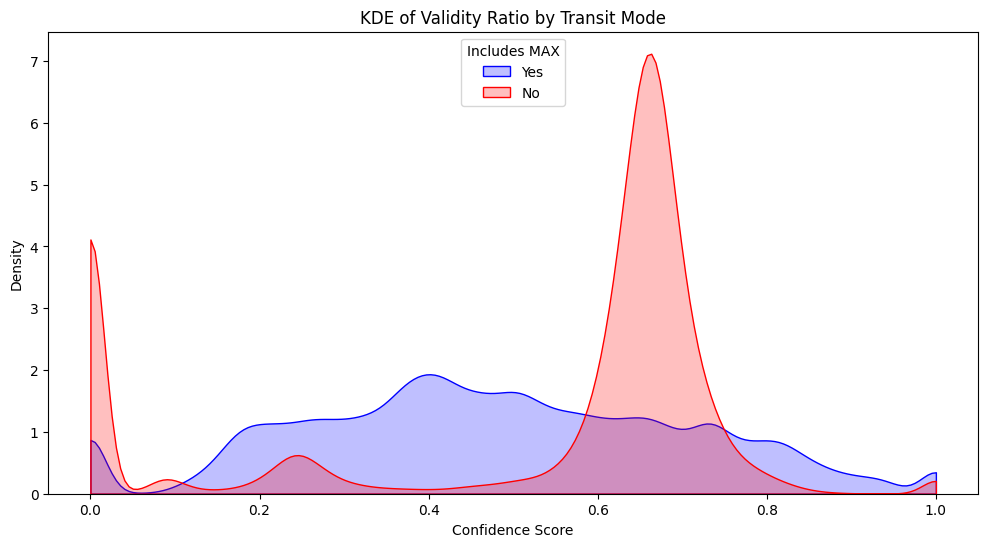

In [73]:
# Create the KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=journey_profiles[journey_profiles["INCLUDES_MAX"] == "Yes"], 
    x="CONFIDENCE_MIN", 
    color="blue",
    fill=True,
    label="Yes",
    cut=0
)

sns.kdeplot(
    data=journey_profiles[journey_profiles["INCLUDES_MAX"] == "No"], 
    x="CONFIDENCE_MIN", 
    color="red",
    fill=True,
    label="No",
    cut=0
)

plt.legend(title = "Includes MAX", loc='upper center')
plt.title("KDE of Validity Ratio by Transit Mode")
plt.xlabel("Confidence Score")
plt.ylabel("Density")


plt.show()

In [74]:
#analyze confidence score cutoffs
journey_profiles.groupby(
    ["INCLUDES_MAX"],as_index=False
    )["CONFIDENCE_MIN"].describe(percentiles = [x/100 for x in range(0,100,10)]).T

,0,1
INCLUDES_MAX,No,Yes
count,1204284.0,309951.0
mean,0.518711,0.480984
std,0.267549,0.226148
min,0.0,0.0
0%,0.0,0.0
10%,0.0,0.195177
20%,0.230205,0.280777
30%,0.588196,0.359451
40%,0.628585,0.411725


# Analyze impacts of confidence score cutoffs

In [76]:
#evaluate impact of cutoff of 0.50 on bus only journeys
cutoff = 0.50
bus_only = journey_profiles[journey_profiles["INCLUDES_MAX"] == "No"]
bus_only["ABOVE_CUTOFF"] = bus_only["CONFIDENCE_MIN"] > cutoff
median_distance_above_cutoff = (bus_only[bus_only["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (bus_only["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (bus_only[bus_only["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (bus_only["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = bus_only[bus_only["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = bus_only["N_LEGS"].mean()-1
# Calculate the number of journeys
journey_count_above_cutoff = bus_only["ABOVE_CUTOFF"].sum()
total_journey_count = len(bus_only)


# Create a table of statistics
stats_table = {
    "Statistic": [
        "Journey Count",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers"
    ],
    "All Journeys": [
        f"{total_journey_count}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}"
    ],
    "Above Cutoff": [
        f"{journey_count_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}"
    ],
    "Percent Change": [
        f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))




/var/folders/ky/ppnwhmms1wd68gb7bjq21xd40000gn/T/ipykernel_60725/3286303238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_only["ABOVE_CUTOFF"] = bus_only["CONFIDENCE_MIN"] > cutoff


                    Statistic All Journeys Above Cutoff Percent Change
                Journey Count      1204284       892904        -25.86%
      Median Distance (miles)         2.63         2.42         -7.79%
Median Journey Time (minutes)        18.53        16.83         -9.17%
     Mean Number of Transfers         0.30         0.30         -1.13%


In [77]:
#evaluate impact of cutoff of 0.50 on includes max journeys
cutoff = 0.20
includes_max = journey_profiles[journey_profiles["INCLUDES_MAX"] == "Yes"]
includes_max["ABOVE_CUTOFF"] = includes_max["CONFIDENCE_MIN"] > cutoff
median_distance_above_cutoff = (includes_max[includes_max["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (includes_max["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (includes_max[includes_max["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (includes_max["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = includes_max[includes_max["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = includes_max["N_LEGS"].mean()-1
journey_count_above_cutoff = includes_max["ABOVE_CUTOFF"].sum()
total_journey_count = len(includes_max)

# Create a table of statistics
stats_table = {
    "Statistic": [
        "Journey Count",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers"
    ],
    "All Journeys": [
        f"{total_journey_count}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}"
    ],
    "Above Cutoff": [
        f"{journey_count_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}"
    ],
    "Percent Change": [
        f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))

                    Statistic All Journeys Above Cutoff Percent Change
                Journey Count       309951       277249        -10.55%
      Median Distance (miles)         3.06         3.16          3.37%
Median Journey Time (minutes)        14.42        14.50          0.58%
     Mean Number of Transfers         0.19         0.16        -14.91%


/var/folders/ky/ppnwhmms1wd68gb7bjq21xd40000gn/T/ipykernel_60725/3544504669.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  includes_max["ABOVE_CUTOFF"] = includes_max["CONFIDENCE_MIN"] > cutoff


# Analyze Impacts of combined Validity and Confidence score Cutoffs



In [79]:
# Define cutoffs for both validity and confidence scores
validity_cutoff = 0.5  # You can adjust this value as needed
confidence_cutoff_no_max = 0.5  # Confidence cutoff for journeys without max
confidence_cutoff_with_max = 0.2  # Confidence cutoff for journeys with max

# Create a new DataFrame with both cutoffs applied
combined_cutoff = journey_profiles[
    (journey_profiles["VALIDITY_SCORE"] > validity_cutoff) & 
    (
        ((journey_profiles['INCLUDES_MAX'] == 'No') & 
         (journey_profiles['CONFIDENCE_MIN'] > confidence_cutoff_no_max)) |
        ((journey_profiles['INCLUDES_MAX'] == 'Yes') & 
         (journey_profiles['CONFIDENCE_MIN'] > confidence_cutoff_with_max))
    )
]
total_n_journeys = len(journey_profiles)
total_n_journeys_above_cutoff = len(combined_cutoff)
median_distance_above_cutoff = (combined_cutoff["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (journey_profiles["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (combined_cutoff["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (journey_profiles["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = combined_cutoff["N_LEGS"].mean()-1
mean_n_transfers = journey_profiles["N_LEGS"].mean()-1
n_bus_only = len(journey_profiles[journey_profiles["INCLUDES_MAX"]=="No"])
n_bus_and_max = len(
    journey_profiles[
        (journey_profiles["INCLUDES_MAX"]=="Yes")&
        (~journey_profiles["IS_MAX_ONLY"])
        ])
n_max_only = len(journey_profiles[journey_profiles["IS_MAX_ONLY"]])
n_bus_only_above_cutoff = len(combined_cutoff[(combined_cutoff["INCLUDES_MAX"]=="No")])
n_bus_and_max_above_cutoff = len(
    combined_cutoff[
        (combined_cutoff["INCLUDES_MAX"]=="Yes") & 
        (~combined_cutoff["IS_MAX_ONLY"])
        ])
n_max_only_above_cutoff = len(combined_cutoff[(combined_cutoff["IS_MAX_ONLY"])])
n_single_stop = len(journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"] == "Yes"])
n_single_stop_above_cutoff = len(combined_cutoff[combined_cutoff["IS_SINGLE_STOP_RIDE"] == "Yes"])

# Create a table of statistics
stats_table = {
    "Statistic": [
        "Total Number of Journeys",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers",
        "Bus Only Journeys",
        "Bus and MAX Journeys",
        "MAX Only Journeys",
        "Single Stop Rides"
    ],
    "All Journeys": [
        f"{total_n_journeys:.2f}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}",
        f"{n_bus_only}",
        f"{n_bus_and_max}",
        f"{n_max_only}",
        f"{n_single_stop}"
    ],
    "Above Cutoff": [
        f"{total_n_journeys_above_cutoff:.2f}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}",
        f"{n_bus_only_above_cutoff}",
        f"{n_bus_and_max_above_cutoff}",
        f"{n_max_only_above_cutoff}",
        f"{n_single_stop_above_cutoff}"
    ],
    "Percent Change": [
        f"{(total_n_journeys_above_cutoff - total_n_journeys) / total_n_journeys * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%",
        f"{(n_bus_only_above_cutoff - n_bus_only) / n_bus_only * 100:.2f}%",
        f"{(n_bus_and_max_above_cutoff - n_bus_and_max) / n_bus_and_max * 100:.2f}%",
        f"{(n_max_only_above_cutoff - n_max_only) / n_max_only * 100:.2f}%",
        f"{(n_single_stop_above_cutoff - n_single_stop) / n_single_stop * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))

                    Statistic All Journeys Above Cutoff Percent Change
     Total Number of Journeys   1514235.00   1007998.00        -33.43%
      Median Distance (miles)         2.67         2.84          6.34%
Median Journey Time (minutes)        17.83        18.37          2.99%
     Mean Number of Transfers         0.28         0.28          0.33%
            Bus Only Journeys      1204284       806857        -33.00%
         Bus and MAX Journeys        40783        27723        -32.02%
            MAX Only Journeys       269168       173418        -35.57%
            Single Stop Rides       133194        19575        -85.30%
